### Dpi Setting

In [1329]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 # 300

In [1330]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1331]:
from package_sampling.sampling import up_tille, up_brewer, up_systematic, up_max_entropy
from package_sampling.utils import inclusion_probabilities


# Dependencies

### Python

In [1332]:
# !pip install -q git+https://github.com/mehdimhb/geometric-sampling@dev
# !pip install git+https://github.com/mehdimhb/geometric-sampling@legacy-measure

In [1333]:
!apt-get install -y r-base
!pip install -q rpy2 tqdm


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [1334]:
from rpy2.robjects.packages import importr


In [1335]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### R

In [1336]:
%%R

if(!require(WaveSampling)){
    install.packages("WaveSampling")
    library(WaveSampling)
}
if(!require(sampling)){
    install.packages("sampling")
    library(sampling)
}
if(!require(BalancedSampling)){
    install.packages("BalancedSampling")
    library(BalancedSampling)
}

### Imports

In [1337]:
import matplotlib as mpl
import numpy as np
from rpy2.robjects import r, numpy2ri
import rpy2.robjects as ro
from matplotlib import pyplot as plt
from itertools import combinations
from collections import OrderedDict
import pandas as pd
import geometric_sampling as gs
from tqdm import tqdm
from tqdm.contrib import tenumerate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

numpy2ri.activate()

rng = gs.random.rng()

## Functions

### Scores in R

In [1338]:
def scores(coords, probs, n, N, sample_idx):
    assert len(coords) == len(probs) == N
    assert len(sample_idx) == n
    sample_mask = np.zeros(N, dtype=int)
    sample_mask[sample_idx] = 1

    ro.globalenv['sample_mask'] = sample_mask
    ro.globalenv['sample_idx'] = sample_idx + 1
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs
    ro.globalenv['n'] = n
    ro.globalenv['N'] = N

    r_code = """
W <- wpik(coords,probs)
W <- W - diag(diag(W))
diag(W) <- 0  # Ensure W has zero diagonal


ib_value <- tryCatch({
  IB(W, sample_mask)  # Moran's Index
}, error = function(e) {
  Inf
})

sb_value <- tryCatch({
  sb(probs, coords, sample_idx)  # Spatial balance
}, error = function(e) {
  Inf
})

sblb_value <- tryCatch({
  sblb(probs, coords, sample_idx)  # Spatial balance using local balance
}, error = function(e) {
  Inf
})
"""
    ro.r(r_code)
    IB_value = ro.r("ib_value")[0]
    SB_value = ro.r("sb_value")[0]
    SBLB_value = ro.r("sblb_value")[0]

    scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
    density_measure = gs.measure.Density(scaled_coords, probs, n)
    scores, _ = density_measure.score(sample_idx.reshape(1, -1))
    return scores[1][0], SB_value, IB_value, SBLB_value
    # Legacy Measure: return scores[3][0], SB_value, IB_value, SBLB_value

# Handpicked Cases

## Linear 1D

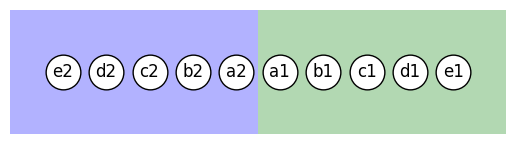

   Sample   # Density Voronai  Moran Local Balance
0   ai aj   1    0.14     0.0  -0.25          0.49
1   ai bi   2    0.14    0.04  -0.06          0.55
2   ai bj   2    0.11    0.04  -0.17          0.39
3   ai ci   2    0.11    0.04    0.0          0.52
4   ai cj   2    0.07    0.04  -0.79          0.36
5   ai di   2    0.07    0.16  -0.24          0.59
6   ai dj   2    0.02    0.16  -0.84          0.47
7   ai ei   2    0.02    0.25   -0.2          0.71
8   ai ej   2     0.0    0.16   -1.0          0.58
9   bi bj   1    0.07     0.0  -0.79          0.25
10  bi ci   2    0.14    0.16   0.06          0.69
11  bi cj   2    0.02    0.01  -0.84          0.18
12  bi di   2    0.11    0.36   0.13          0.76
13  bi dj   2     0.0    0.04   -1.0          0.28
14  bi ei   2    0.07    0.36  -0.13          0.85
15  bi ej   2    0.03    0.04  -0.76          0.42
16  ci cj   1     0.0     0.0   -1.0           0.0
17  ci di   2    0.14    0.36   0.19          0.89
18  ci dj   2    0.03    0.01  

In [1339]:
points = {
    (0.35,): "a1",
    (-0.35,): "a2",
    (1.05,): "b1",
    (-1.05,): "b2",
    (1.75,): "c1",
    (-1.75,): "c2",
    (2.45,): "d1",
    (-2.45,): "d2",
    (3.15,): "e1",
    (-3.15,): "e2",
}

N = len(points)
n = 2
coords = np.array(list(points.keys()))
probs = rng.equal_probabilities(n, N)
fig, ax = plt.subplots()
for (x,), label in points.items():
    ax.plot(x, 0, 'o', markersize=25, markerfacecolor='white', markeredgecolor='black', markeredgewidth=1)
    ax.text(x, 0, label, color="black", ha="center", va="center", fontsize=12)
ax.set_xlim(-4, 4)
ax.set_ylim(-1, 1)
ax.set_aspect("equal")
ax.axis("off")
ax.axvspan(0, 4, facecolor='green', alpha=0.3)
ax.axvspan(-4, 0, facecolor='blue', alpha=0.3)

plt.show()

dic_score = {}
for i, j in combinations(range(0, N), 2):
    i_label, j_label = points[tuple(coords[i])], points[tuple(coords[j])]
    if i_label[1] == j_label[1]:
        identifier = f"{i_label[0]}i {j_label[0]}i"
    else:
        identifier = f"{i_label[0]}i {j_label[0]}j"
    sample_idx = np.array([i, j])
    dic_score.setdefault(identifier, [])
    dic_score[identifier].append(np.array(scores(coords, probs, n, N, sample_idx)))

result = []
for i, s in dic_score.items():
    ss = np.round(np.mean(s, axis=0), 2)
    row = np.concatenate([[i, len(s)], ss])
    result.append(row)

all_scores = np.concatenate([s for s in dic_score.values()])
overall_mean = np.round(np.mean(all_scores, axis=0), 2)


result.append(
    np.concatenate([["Mean", len(all_scores)], overall_mean])
)

df = pd.DataFrame(result, columns=["Sample", "#", "Density", "Voronai", "Moran", "Local Balance"])
# print(df.to_latex(index=False))
print(df)

## 4 3x3

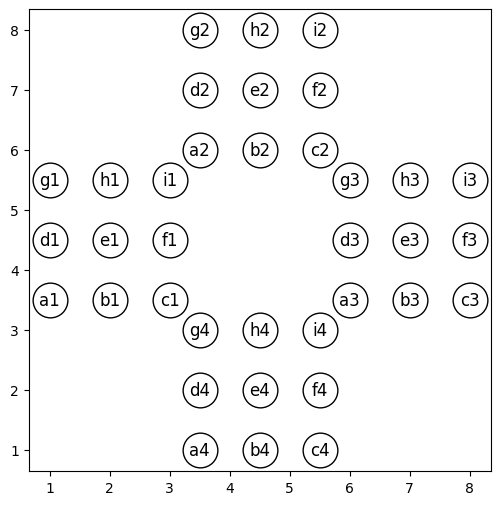

,Sample,Density,Voronai,Moran,Local Balance
0,e1 e2 e3 e4,0.00,0.00,-1.00,0.00
1,a1 a2 a3 a4,0.00,0.11,-0.59,0.43
2,d1 d2 d3 d4,0.00,0.02,-0.83,0.28
3,b1 d2 h3 f4,0.02,0.00,-0.75,0.19
4,f1 b2 d3 h4,0.33,0.00,-0.69,0.26
5,d1 h2 f3 b4,0.40,0.00,-0.50,0.26
6,a1 c1 g1 i1,0.34,0.56,0.38,0.84
7,b1 d1 f1 h1,0.48,0.56,0.52,0.79
8,h1 d2 b3 f4,0.03,0.00,-0.00,0.26


\begin{tabular}{llllll}
\toprule
 & Sample & Density & Voronai & Moran & Local Balance \\
\midrule
0 & e1 e2 e3 e4 & 0.00 & 0.00 & -1.00 & 0.00 \\
1 & a1 a2 a3 a4 & 0.00 & 0.11 & -0.59 & 0.43 \\
2 & d1 d2 d3 d4 & 0.00 & 0.02 & -0.83 & 0.28 \\
3 & b1 d2 h3 f4 & 0.02 & 0.00 & -0.75 & 0.19 \\
4 & f1 b2 d3 h4 & 0.33 & 0.00 & -0.69 & 0.26 \\
5 & d1 h2 f3 b4 & 0.40 & 0.00 & -0.50 & 0.26 \\
6 & a1 c1 g1 i1 & 0.34 & 0.56 & 0.38 & 0.84 \\
7 & b1 d1 f1 h1 & 0.48 & 0.56 & 0.52 & 0.79 \\
8 & h1 d2 b3 f4 & 0.03 & 0.00 & -0.00 & 0.26 \\
\bottomrule
\end{tabular}



In [1340]:
samples = np.array([
    ["e1", "e2", "e3", "e4"],
    ["a1", "a2", "a3", "a4"],
    ["d1", "d2", "d3", "d4"],
    ["f4", "h3", "d2", "b1"],
    ["f1", "b2", "d3", "h4"],
    ["f3", "d1", "b4", "h2"],
    ["a1", "c1", "g1", "i1"],
    ["b1", "d1", "f1", "h1"],
    #### NEW Interstings
    "h1 d2 b3 f4".split(" "),
])

x3coords = rng.grid_coordinates((3, 2)) * 2
x3probs = rng.equal_probabilities(1, 9)

left = x3coords.copy()
right = x3coords.copy()
up = x3coords.copy()
down = x3coords.copy()

left_labels = [chr(ord('a') + i) + '1' for i in range(9)]
right_labels = [chr(ord('a') + i) + '3' for i in range(9)]
up_labels = [chr(ord('a') + i) + '2' for i in range(9)]
down_labels = [chr(ord('a') + i) + '4' for i in range(9)]

####### TEST
import itertools
# samples = np.array([
#     [l, u, r, d]
#     for l, u, r, d in itertools.product(left_labels, up_labels, right_labels, down_labels)
# ])
#######

left[:, 0] += 1
left[:, 1] += 3.5
right[:, 0] += 6
right[:, 1] += 3.5
up[:, 0] += 3.5
up[:, 1] += 6
down[:, 0] += 3.5
down[:, 1] += 1


coords = np.vstack([left, right, up, down])
probs = np.concatenate([x3probs, x3probs, x3probs, x3probs])
labels = np.concatenate([left_labels, right_labels, up_labels, down_labels])
label_to_idx = {l: idx for idx, (c, l) in enumerate(zip(coords, labels))}
assert len(probs) == len(coords) == len(labels)

N = len(coords)
n = 4
points = {}
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect("equal")
for (x, y), label in zip(coords, labels):
    points[label] = (x, y)
    ax.plot(x, y, 'o', markersize=25, markerfacecolor='white', label=1, markeredgecolor='black', markeredgewidth=1)
    ax.text(x, y, label, fontsize=12, ha='center', va='center')

plt.show()

results = []
for sample in samples:
    sample_idx = np.array([label_to_idx[s] for s in sample])
    identifier = " ".join(sorted(sample, key=lambda x: x[1]))
    s = scores(coords, probs, n, N, sample_idx)
    s_formatted = [f"{num:.2f}" for num in s]  # Corrected line
    results.append([identifier] + s_formatted)

df = pd.DataFrame(results, columns=["Sample", "Density", "Voronai", "Moran", "Local Balance"])
display(df)
print(df.to_latex())


## Rotating

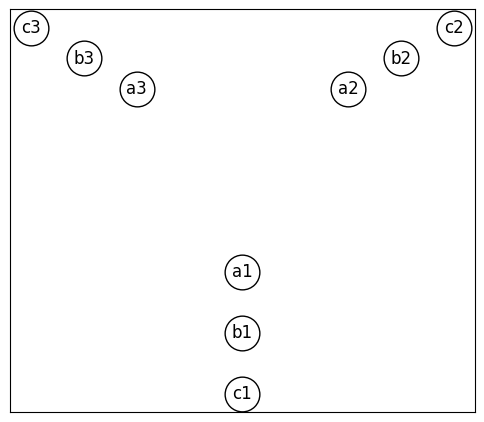

,Sample,#,Density,Voronai,Moran,Local Balance
0,aaa,1,0.56,0.0,-1.0,0.263
1,aab,3,0.3,0.0,-1.0,0.214
2,aac,3,0.141,0.0,-1.0,0.263
3,abb,3,0.101,0.0,-1.0,0.152
4,abc,6,0.045,0.0,-1.0,0.214
5,acc,3,0.039,0.0,-1.0,0.263
6,bbb,1,0.0,0.0,-1.0,0.0
7,bbc,3,0.067,0.0,-1.0,0.152
8,bcc,3,0.161,0.0,-1.0,0.214
9,ccc,1,0.223,0.0,-1.0,0.263


In [1341]:
def rotate_point(p, t, cost=None, sint=None):
    if cost is None or sint is None:
        cost, sint = np.cos(t), np.sin(t)
    return np.array([
        p[0] * cost - p[1] * sint,
        p[0] * sint + p[1] * cost
    ])

def rotate_matrix(matrix, t, cost=None, sint=None):
    if cost is None or sint is None:
        cost, sint = np.cos(t), np.sin(t)
    return np.apply_along_axis(rotate_point, 1, matrix, t, cost, sint)

template = np.array([
    [0.0, -0.5],
    [0.0, -1],
    [0.0, -1.5]
])
template = np.array([
    [0.0, -2],
    [0.0, -3],
    [0.0, -4]
])

angles = np.arange(0, 3) * (2.0 * np.pi / 3.0)
pop = np.vstack([rotate_matrix(template, angle) for angle in angles])

all_points = pop
labels = ["a1", "b1", "c1", "a2", "b2", "c2", "a3", "b3", "c3"]

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect("equal")

for (x, y), label in zip(all_points, labels):
    ax.plot(x, y, 'o', markersize=25, markerfacecolor='white', markeredgecolor='black', markeredgewidth=1)
    ax.text(x, y, label, fontsize=12, ha='center', va='center')

ax.set_xticks([])
ax.set_yticks([])
plt.show()

N = len(all_points)
n = 3
coords = np.array(all_points)
probs = rng.equal_probabilities(n, N)

from itertools import combinations, combinations_with_replacement

dic_score = {}
for i, j, k in combinations(range(0, N), 3):
    i_label, j_label, k_label = labels[i], labels[j], labels[k]
    ids = list(sorted([i_label[0], j_label[0], k_label[0]]))
    identifier = "".join(ids)

    if len(set([i_label[1], j_label[1], k_label[1]])) != n:
      continue

    sample_idx = np.array([i, j, k])
    dic_score.setdefault(identifier, [])
    dic_score[identifier].append(np.array(scores(coords, probs, n, N, sample_idx)))

result = []
for i, s in dic_score.items():
    ss = np.round(np.mean(s, axis=0), 3)
    row = np.concatenate([[i, len(s)], ss])
    result.append(row)

all_scores = np.concatenate([s for s in dic_score.values()])
overall_mean = np.mean(all_scores, axis=0)


result.append(
    np.concatenate([["Mean", len(all_scores)], np.round(overall_mean, 2)])
)

df = pd.DataFrame(result, columns=["Sample", "#", "Density", "Voronai", "Moran", "Local Balance"])

display(df)
# print(df.to_latex())

# Simulations

## Methods

In [1342]:
def local_pivotal_samples(coords, probs, n, num_samples):
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
s <- lpm(probs, coords) # Local Pivotal Method
"""
        ro.r(r_code)
        sample_idx = np.array(list(ro.r("s"))) - 1
        samples_idx[i] = sample_idx

    return samples_idx

def k_means_samples(coords, probs, n, num_samples, n_zones):
    return gs.sampling.KMeansSpatialSampling(coords, probs, n=n, n_zones=n_zones, tolerance=3).sample(num_samples)

def random_samples(coords, probs, n, num_samples):
    return gs.sampling.RandomSampling(coords, probs, n=n).sample(num_samples)

def upmaxentropy_samples(probs, num_samples):
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
        mask <- UPmaxentropy(probs)
        """
        ro.r(r_code)
        mask = np.array(ro.r("mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx

    return np.array(samples)


def wave_samples(coords, probs, n, num_samples):
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
wave_mask <- wave(coords, probs)
"""
        ro.r(r_code)
        mask = np.array(ro.r("wave_mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx


def find_samples(coords, probs, n, num_samples):
    return {
        "K-Means (2, 2)": k_means_samples(coords, probs, n, num_samples, (2, 2)),
        "K-Means (5, 5)": k_means_samples(coords, probs, n, num_samples, (5, 5)),
        "Local Pivotal": local_pivotal_samples(coords, probs, n, num_samples),
        "Random": random_samples(coords, probs, n, num_samples),
        "UPmaxentropy": upmaxentropy_samples(probs, num_samples),
        # "Wave": wave_samples(coords, probs, n, num_samples),
    }

## Initial Population

In [1343]:
n = 10 # Number of item in each sample (number of clusters)
sample_cnt = 5 # How many sample gather from each desiging method

### Coords

Uncomment each one you would like to get result from

In [ ]:
swiss = 0
######### GRID
# grid_size = 20
# N = grid_size**2
# coords = rng.grid_coordinates((grid_size, 2))


######### RANDOM
N = 400
coords = rng.random_coordinates((N, 2))

######### CLUSTRED
# n_clusters = 4
# cluster_std = 0.05
# N = 400
# coords = rng.cluster_coordinates(n_clusters, cluster_std, (N, 2))
# idx = np.lexsort((coords[:,1], coords[:,0]))
# coords = coords[idx]


######### SWISS: https://docs.google.com/spreadsheets/d/10uYLsZpxRV5lUrsGfy3gI0RD4fAn8lIP/edit?usp=sharing&ouid=117333816980669142577&rtpof=true&sd=true
swiss = 1
swiss_df = pd.read_csv('/home/divar/projects/geometric-sampling/swiss.csv')
coords = swiss_df[['COORD_X', 'COORD_Y']].to_numpy()
swiss_df['AREA'] = swiss_df['AREA'].clip(lower=1, upper=40)
N = len(coords)

### Probabilities

Uncomment each one you would like to get result from

In [ ]:
######### EQUAL
probs = rng.equal_probabilities(n, N)


######### UNEQUAL
probs = np.sort(rng.unequal_probabilities(n, N))

if swiss == 1:
    probs = inclusion_probabilities(swiss_df['AREA'].to_numpy(), n)


count    959.000000
mean       0.010428
std        0.011114
min        0.000825
25%        0.001452
50%        0.005370
75%        0.016093
max        0.032994
dtype: float64
10.000000000000059
10.0
[0.00868558 0.00383551 0.00082484 0.01497912 0.01936728 0.022147
 0.00375303 0.01539154 0.03065936 0.0015837  0.00387676 0.0179568
 0.00510577 0.02476174 0.00772052 0.0171897  0.02122317 0.00541921
 0.02429983 0.01684327 0.01238087 0.00082484 0.01689276 0.0041902
 0.00802571 0.03299366 0.01938378 0.00323338 0.00474284 0.00504803
 0.01079718 0.00121252 0.00996409 0.01528431 0.00082484 0.02652691
 0.03299366 0.01514409 0.00564192 0.00087433 0.01294176 0.00082484
 0.00245803 0.00375303 0.00561717 0.0140388  0.00800921 0.00449539
 0.00574915 0.01306549 0.00544395 0.00222707 0.00082484 0.01281804
 0.00269723 0.0073081  0.00724211 0.00737408 0.01484715 0.0098816
 0.00762154 0.01917757 0.03299366 0.00082484 0.02977678 0.00416545
 0.01125909 0.00082484 0.00600485 0.00648325 0.00261475 0.01334594
 0

In [1346]:
# sampling = importr('sampling')
# r_x = ro.FloatVector(swiss_df['AREA'].to_numpy())

# # Calculate inclusion probabilities using R's inclusionprobabilities
# probs = sampling.inclusionprobabilities(r_x, n)
# print(probs.sum())


## Results

### Plotting coords

Plotting clusters: 100%|██████████| 10/10 [00:00<00:00, 490.11it/s]


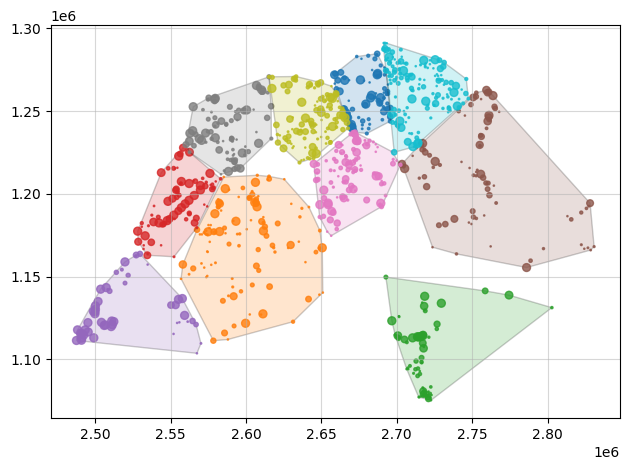

In [1347]:
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon

def plot_convex_hull(
        points, ax, color, alpha=0.3, edge_color="black", line_width=1.0
    ):
        if len(points) < 3:
            return ax, None
        hull = ConvexHull(points)
        polygon = Polygon(
            points[hull.vertices],
            closed=True,
            facecolor=color,
            alpha=alpha,
            edgecolor=edge_color,
            lw=line_width,
        )
        ax.add_patch(polygon)
        return ax, hull

density_measure = gs.measure.Density(coords, probs, n)
clusters, centroids = density_measure.clusters, density_measure.centroids
fig, ax = plt.subplots()
for cluster_idx, cluster in tqdm(enumerate(clusters), total=len(clusters), desc="Plotting clusters"):
    cluster_points = cluster[:, 1:3]
    cluster_color = plt.cm.tab10(cluster_idx % 10)
    cmap = plt.get_cmap('tab10')         # get the colormap object
    n_colors = cmap.N                  # how many entries it has
    cluster_color = cmap(cluster_idx % n_colors)    # 
    ax, _ = plot_convex_hull(cluster_points, ax, color=cluster_color, alpha=0.2)
    ax.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        color=cluster_color,
        s=cluster[:, 3] * 1000,
        alpha=0.8,
    )
    ax.grid(alpha=0.5)
    # ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    # ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

plt.tight_layout()
plt.show()
# ax.show()

### Gathering Data

In [1349]:
columns = ["Method", "Density", "Voronoi", "Moran", "Local Balance"]

sample_methods = find_samples(coords, probs, n, sample_cnt)

rows = np.array([
    [method, *scores(coords, probs, n, N, s)]
    for method, samples in sample_methods.items()
    for s in tqdm(samples, total=sample_cnt)
])

df = pd.DataFrame(rows, columns=columns)
df = df.astype({
    "Density": float,
    "Voronoi": float,
    "Moran": float,
    "Local Balance": float
})

100%|██████████| 5/5 [02:40<00:00, 32.16s/it]


### Tables

Means

In [1350]:
df.groupby("Method").mean()

,Density,Voronoi,Moran,Local Balance
Method,,,,
"K-Means (2, 2)",0.052521,0.104480,-0.132247,0.575876
"K-Means (5, 5)",0.079332,0.094277,-0.118811,0.847798
Local Pivotal,0.144679,0.126731,-0.069680,0.608796
Random,0.332791,0.435481,-0.009358,3.707992
UPmaxentropy,0.352818,0.297779,-0.026961,1.095626


STD

In [1351]:
df.groupby("Method").std()

,Density,Voronoi,Moran,Local Balance
Method,,,,
"K-Means (2, 2)",0.021885,0.027258,0.032126,0.574739
"K-Means (5, 5)",0.025093,0.051352,0.041866,0.597053
Local Pivotal,0.045699,0.054092,0.030917,0.645070
Random,0.172376,0.181765,0.027275,1.334099
UPmaxentropy,0.140263,0.119908,0.042434,1.343181


Describe

In [1352]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  display(df.groupby("Method").describe())

Density                                                    \
                 count      mean       std       min       25%       50%   
Method                                                                     
K-Means (2, 2)     5.0  0.052521  0.021885  0.034609  0.034920  0.045250   
K-Means (5, 5)     5.0  0.079332  0.025093  0.050864  0.053721  0.091077   
Local Pivotal      5.0  0.144679  0.045699  0.090869  0.120934  0.129997   
Random             5.0  0.332791  0.172376  0.087652  0.229068  0.380641   
UPmaxentropy       5.0  0.352818  0.140263  0.180377  0.232889  0.414857   

                                   Voronoi                                \
                     75%       max   count      mean       std       min   
Method                                                                     
K-Means (2, 2)  0.061320  0.086505     5.0  0.104480  0.027258  0.071151   
K-Means (5, 5)  0.097477  0.103522     5.0  0.094277  0.051352  0.033747   
Local Pivotal   0.176221  0.205374     5.0  0.126731  0.054092  0.063370   
Random          0.469002  0.497593     5.0  0.435481  0.181765  0.198934   
UPmaxentropy    0.422154  0.513813     5.0  0.297779  0.119908  0.126497   

                                                       Moran            \
                     25%       50%       75%       max count      mean   
Method                                                                   
K-Means (2, 2)  0.085174  0.109111  0.115937  0.141028   5.0 -0.132247   
K-Means (5, 5)  0.060177  0.086498  0.131042  0.159923   5.0 -0.118811   
Local Pivotal   0.095624  0.109402  0.173360  0.191899   5.0 -0.069680   
Random          0.370227  0.395686  0.528771  0.683785   5.0 -0.009358   
UPmaxentropy    0.228572  0.344226  0.360152  0.429450   5.0 -0.026961   

                                                                            \
                     std       min       25%       50%       75%       max   
Method                                                                       
K-Means (2, 2)  0.032126 -0.168704 -0.145714 -0.141014 -0.123131 -0.082670   
K-Means (5, 5)  0.041866 -0.169045 -0.158627 -0.100075 -0.085212 -0.081097   
Local Pivotal   0.030917 -0.107856 -0.087096 -0.073192 -0.052451 -0.027804   
Random          0.027275 -0.052131 -0.011215 -0.009591  0.004817  0.021329   
UPmaxentropy    0.042434 -0.066309 -0.045631 -0.038650 -0.029119  0.044903   

               Local Balance                                          \
                       count      mean       std       min       25%   
Method                                                                 
K-Means (2, 2)           5.0  0.575876  0.574739  0.307420  0.313693   
K-Means (5, 5)           5.0  0.847798  0.597053  0.330689  0.337847   
Local Pivotal            5.0  0.608796  0.645070  0.278582  0.317055   
Random                   5.0  3.707992  1.334099  2.437838  2.971639   
UPmaxentropy             5.0  1.095626  1.343181  0.383489  0.443745   

                                              
                     50%       75%       max  
Method                                        
K-Means (2, 2)  0.324044  0.330345  1.603877  
K-Means (5, 5)  0.811995  0.971607  1.786854  
Local Pivotal   0.329282  0.357443  1.761618  
Random          3.446431  3.764231  5.919823  
UPmaxentropy    0.458238  0.704322  3.488337

### Plots

##### Color Pallet

In [1353]:
methods = df["Method"].unique()
method_palette = dict(zip(methods, sns.color_palette("Pastel1", n_colors=len(methods))))

##### Boxplot

In [1354]:
def remove_outliers(dataframe, column, IQR_coef, groupby_col=None):
    if groupby_col:
        def outlier_filter(group):
            Q1 = group[column].quantile(0.25)
            Q3 = group[column].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - IQR_coef * IQR
            upper = Q3 + IQR_coef * IQR
            return group[(group[column] >= lower) & (group[column] <= upper)]

        return dataframe.groupby(groupby_col, group_keys=False).apply(outlier_filter)
    else:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - IQR_coef * IQR
        upper = Q3 + IQR_coef * IQR
        return dataframe[(df[column] >= lower) & (dataframe[column] <= upper)]

    return df

/tmp/ipykernel_81327/3298180823.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return dataframe.groupby(groupby_col, group_keys=False).apply(outlier_filter)
/tmp/ipykernel_81327/3298180823.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return dataframe.groupby(groupby_col, group_keys=False).apply(outlier_filter)
/tmp/ipykernel_81327/3298180823.py:11: DeprecationWarning: DataFrameGroupBy.apply op

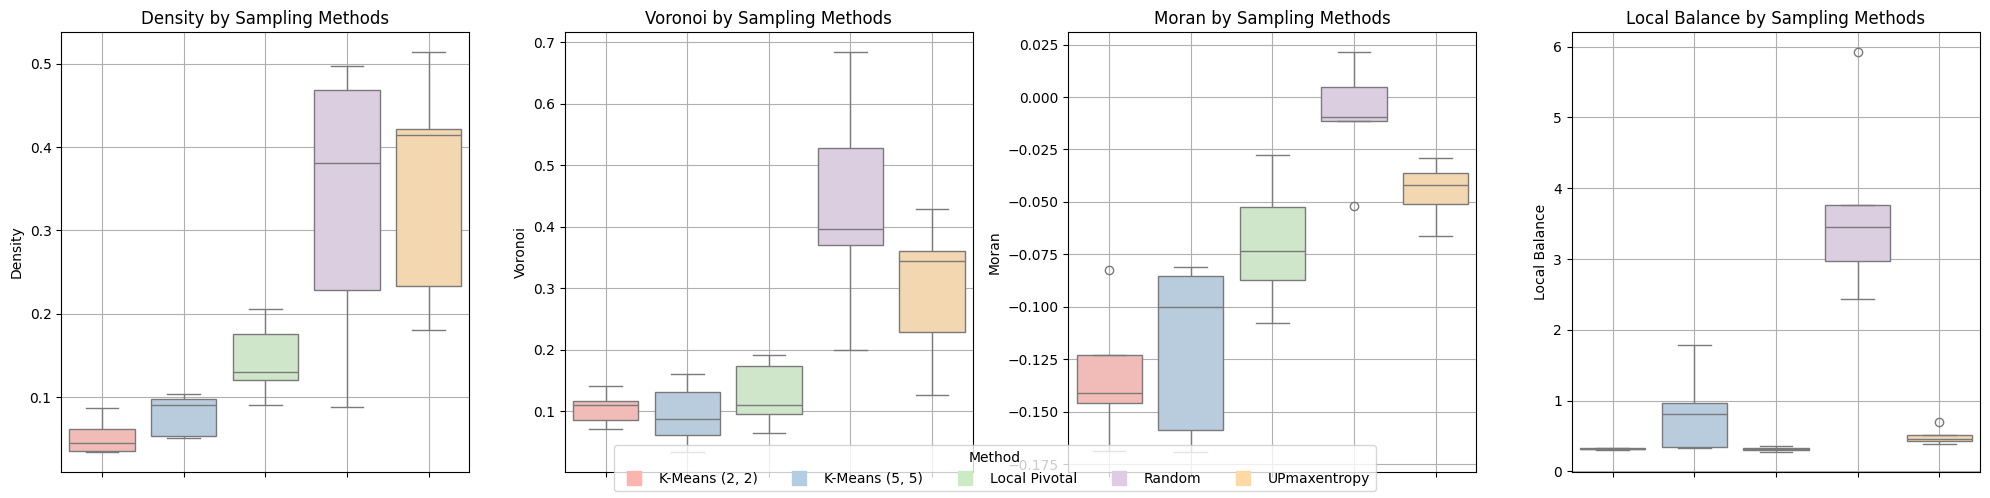

In [1355]:
number_of_items = len(columns[1:])
n_cols = 4  # how many plots per row
n_rows = (number_of_items + n_cols - 1) // n_cols  # compute needed rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

axes = axes.flatten()

for idx, column in enumerate(columns[1:]):
    sns.boxplot(x="Method", y=column, data=remove_outliers(df, column, IQR_coef=3, groupby_col="Method"), hue="Method", palette=method_palette, ax=axes[idx])
    axes[idx].set_title(f'{column} by Sampling Methods')
    axes[idx].set_xlabel("")
    axes[idx].set_xticklabels([])
    axes[idx].grid(True)

handles = [plt.Line2D([0], [0], color=color, marker='s', linestyle='', markersize=10, label=method) for method, color in method_palette.items()]
fig.legend(handles=handles, loc='lower center', ncol=len(methods), fontsize=10, title="Method")

fig.tight_layout()
plt.show()